In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import gc

from tcnAutoencoder import TCNAutoencoder

In [2]:
# if in jupyter notebook, don't run this cell
if False: 
    import argparse

    # Parse command line arguments
    parser = argparse.ArgumentParser()
    parser.add_argument("--ticker", default="*", type=str, help="Ticker value")
    parser.add_argument("--alias", type=str, help="Alias value")
    args = parser.parse_args()

    # Access the values of the arguments
    ticker = args.ticker
    alias = args.alias

    # Print the values for testing
    print("Ticker:", ticker)
    print("Alias:", alias)
else:
    ticker = "INTC"
    alias = "INTC"

In [3]:
def prep_data(df) -> pd.DataFrame:
    df = df[['Price', 'Size']]
    df.head()

    # sample every 100ms, and the size would be the sum of the size in that 100ms. 
    # Price would be the average price in that 100ms.
    df = df.resample('100ms').agg({'Price': 'mean', 'Size': 'sum'})

    # Check for NaN values

    # forwardfill all NaN values in the data
    df = df.ffill()

    # normalize the data with mean and std
    mean = df['Price'].mean()
    std = df['Price'].std()
    df['Price'] = (df['Price'] - mean) / std

    mean = df['Size'].mean()
    std = df['Size'].std()
    df['Size'] = (df['Size'] - mean) / std

    print("original shape: ", df.shape)

    df = df.values
    # Create a tensor for every 30 minutes of data
    tensors = []
    for i in range(0, len(df), 6000):
        if i + 18000 <= len(df):
            # flip the first and second dimension, so that the shape is (batch_size, channel, sequence_length)
            tensors.append(torch.tensor(df[i:i+18000], dtype = torch.float32).unsqueeze(0))
        # if it's less than 30 minutes, then we just ignore it. 
        
    del df
    gc.collect()
    
    print(f"{len(tensors)} tensor(s) created.")
            
    return tensors

    # Create the final torch tensor, every 1 hour is a sequence

tensors_list = []


In [4]:
# %load load_data.py
import pandas as pd
import glob, os, re


# Read the data only once.  It's big!
csv_files = glob.glob(os.path.join(".", "data", "hft_data", ticker, "*_message_*.csv"))
date_str = re.compile(r'_(\d{4}-\d{2}-\d{2})_')
stock_str = re.compile(r'([A-Z]+)_\d{4}-\d{2}-\d{2}_')

df_list = []
day_list = []
sym_list = []

for csv_file in sorted(csv_files):
    date = date_str.search(csv_file)
    date = date.group(1)
    day_list.append(date)

    symbol = stock_str.search(csv_file)
    symbol = symbol.group(1)
    sym_list.append(symbol)

    # Find the order book file that matches this message file.
    book_file = csv_file.replace("message", "orderbook")

    # Read the message file and index by timestamp.
    df = pd.read_csv(csv_file, names=['Time','EventType','OrderID','Size','Price','Direction'])
    df['Time'] = pd.to_datetime(date) + pd.to_timedelta(df['Time'], unit='s')

    # Read the order book file and merge it with the messages.
    names = [f"{x}{i}" for i in range(1,11) for x in ["AP","AS","BP","BS"]]
    df = df.join(pd.read_csv(book_file, names=names), how='inner')
    df = df.set_index(['Time'])

    BBID_COL = df.columns.get_loc("BP1")
    BASK_COL = df.columns.get_loc("AP1")

    print (f"Read {df.shape[0]} unique order book shapshots from {csv_file}")
    
    tensors_list.extend(prep_data(df))

days = len(day_list)

Read 993824 unique order book shapshots from ./data/hft_data/INTC/INTC_2024-03-04_34200000_57600000_message_10.csv
original shape:  (234000, 2)
37 tensor(s) created.
Read 1048469 unique order book shapshots from ./data/hft_data/INTC/INTC_2024-03-05_34200000_57600000_message_10.csv
original shape:  (234000, 2)
37 tensor(s) created.
Read 1317784 unique order book shapshots from ./data/hft_data/INTC/INTC_2024-03-06_34200000_57600000_message_10.csv
original shape:  (234000, 2)
37 tensor(s) created.
Read 1039638 unique order book shapshots from ./data/hft_data/INTC/INTC_2024-03-07_34200000_57600000_message_10.csv
original shape:  (234000, 2)
37 tensor(s) created.
Read 1490047 unique order book shapshots from ./data/hft_data/INTC/INTC_2024-03-08_34200000_57600000_message_10.csv
original shape:  (234000, 2)
37 tensor(s) created.


In [5]:
# filp the first and second dimension, so that the shape is (batch_size, channel, sequence_length)
tensors_list = [tensor.permute(0, 2, 1) for tensor in tensors_list]

print(f"{len(tensors_list) = }")

dims = [tensor.shape[1] for tensor in tensors_list]



# check if all dims are the same
print(all(x == dims[0] for x in dims))


len(tensors_list) = 185
True


In [6]:
# Start the training process with tensors.

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device {device}")

def initialize_weights(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

def log_cosh_loss(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    def _log_cosh(x: torch.Tensor) -> torch.Tensor:
        return x + torch.nn.functional.softplus(-2. * x) - np.log(2.0)
    return torch.mean(_log_cosh(y_pred - y_true))

class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(
        self, y_pred: torch.Tensor, y_true: torch.Tensor
    ) -> torch.Tensor:
        return log_cosh_loss(y_pred, y_true)

model = TCNAutoencoder(input_dim=(2, 18000)).to(device)
model.apply(initialize_weights)

criterion = LogCoshLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

import tqdm

# Randomly sample 0.2 of the data from the batch for testing, excluding them for traning.
tensors = tensors_list
np.random.shuffle(tensors)
tensors_train = tensors[:int(len(tensors) * 0.8)]
tensors_test = tensors[int(len(tensors) * 0.8):]

Using device cuda


In [7]:
def check_gradients(model):
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    print(f'Total Gradient Norm: {total_norm}')


In [8]:
# Train the model

import time
losses = []
test_losses = []
for epoch in range(1000):
    # time each epoch
    start_time = time.time()

    # shuffle the data
    np.random.shuffle(tensors_train)

    # create a mini-batch of 32
    data = torch.cat(tensors_train[:32], dim=0).to(device)
    
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, data)
    loss.backward()
    # This line is not needed as my model does not have exploding gradients
    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)

    optimizer.step()
    # print(f"Epoch: {epoch}, Loss: {loss.item()}")
    losses.append(loss.item())
    # print(f"Time taken (seconds): {time.time() - start_time}")
    if epoch % 10 == 0:
        # test the model
        model.eval()
        check_gradients(model)
        test_data = torch.cat(tensors_test, dim=0).to(device)
        test_output = model(test_data)
        test_loss = criterion(test_output, test_data)
        print(f"Epoch: {epoch}, Loss: {loss.item()}")
        print(f"\t\tTest Loss: {test_loss.item()}")
        # save a model
        test_losses.append((epoch, test_loss.item()))
        model.train()


# final OOS test
model.eval()
check_gradients(model)
test_data = torch.cat(tensors_test, dim=0).to(device)
test_output = model(test_data)
test_loss = criterion(test_output, test_data)
print(f"\t\tTest Loss: {test_loss.item()}")
# save a model
test_losses.append((epoch, test_loss.item()))

# save a final model
# torch.save(model.state_dict(), f"{alias}_model_final.plt")
# print(f"Model saved as {alias}_model_final.plt")

    

/mnt/local/python3.11/lib/python3.11/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv1d(input, weight, bias, self.stride,


Total Gradient Norm: 0.1416685217824484
Epoch: 0, Loss: 0.23987676203250885
		Test Loss: 0.2160053551197052
Total Gradient Norm: 0.1441827962913556
Epoch: 20, Loss: 0.28007498383522034
		Test Loss: 0.21211136877536774
Total Gradient Norm: 0.2258295521032155
Epoch: 40, Loss: 0.2426721453666687
		Test Loss: 0.19941626489162445
Total Gradient Norm: 0.5322673609627564
Epoch: 60, Loss: 0.14888447523117065
		Test Loss: 0.1415109783411026
Total Gradient Norm: 0.494395708297462
Epoch: 80, Loss: 0.08094529807567596
		Test Loss: 0.07754247635602951
Total Gradient Norm: 0.07149637613783691
Epoch: 100, Loss: 0.06746844947338104
		Test Loss: 0.06929301470518112
Total Gradient Norm: 0.1565494197242842
Epoch: 120, Loss: 0.05690456181764603
		Test Loss: 0.06645732372999191
Total Gradient Norm: 0.07742065504943942
Epoch: 140, Loss: 0.07290150225162506
		Test Loss: 0.06445013731718063
Total Gradient Norm: 0.05164045931747536
Epoch: 160, Loss: 0.06253586709499359
		Test Loss: 0.06334521621465683
Total Gr

Loss plot saved as AAPLloss_plot.png


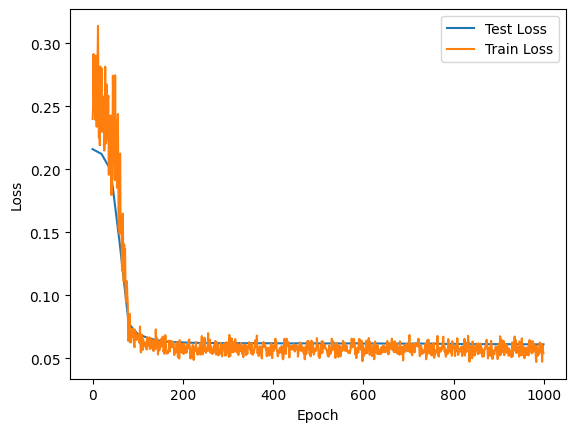

In [9]:
# plot the loss
epochs, t_losses = zip(*test_losses)
plt.plot(epochs, t_losses)
# overlay the training loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Test Loss', 'Train Loss'])
# save the plot in the current directory
plt.savefig(f'{alias}loss_plot.png')
print(f"Loss plot saved as {alias}loss_plot.png")


# Run another 1000 epochs

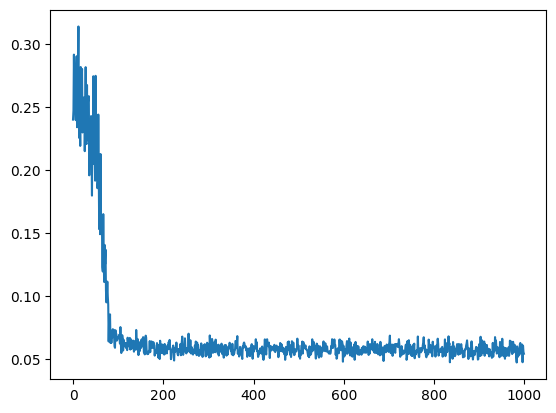

In [10]:
plt.plot(losses)